<a href="https://colab.research.google.com/github/SachinLamichhane/Google-Colabs/blob/main/FullandFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:

data_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database'




 **Create directories for training and validation data**

In [100]:
train_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_train'
validation_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

##  Create class subdirectories in training and validation directories

In [101]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Create class subdirectories in training and validation directories
class_names = ['Tuberculosis', 'Normal']  # Adjust class names accordingly
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

In [102]:
class_names = ['Tuberculosis', 'Normal']
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


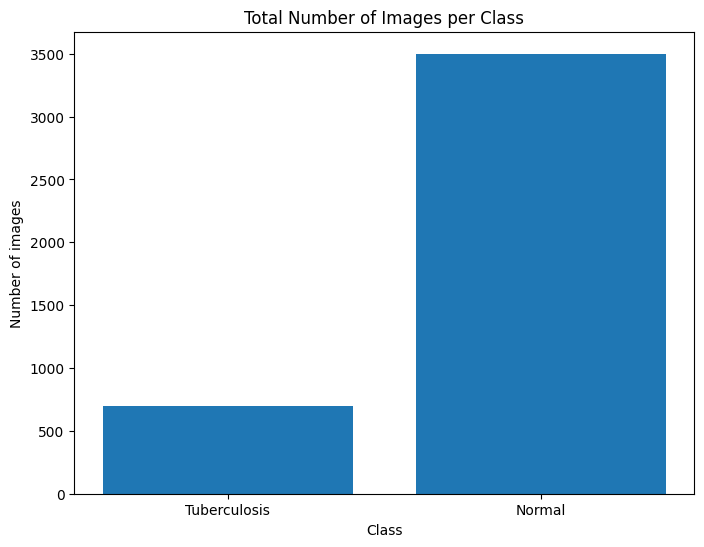

In [103]:
# Convert labels to numeric format
label_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
labels = np.array([label_dict[label] for label in labels])

# Plot total number of images per class
def plot_distribution(data, title):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, [np.sum(data == label_dict[class_name]) for class_name in class_names])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

# Plot initial distribution of images
plot_distribution(labels, 'Total Number of Images per Class')

## Split data into training and validation sets

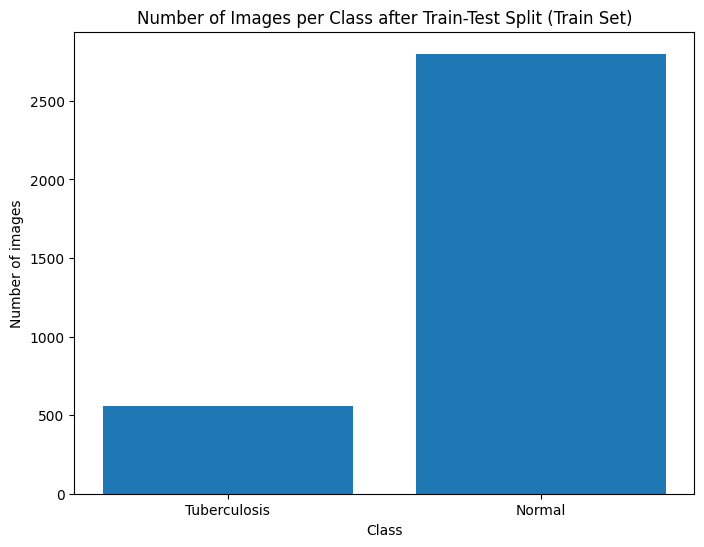

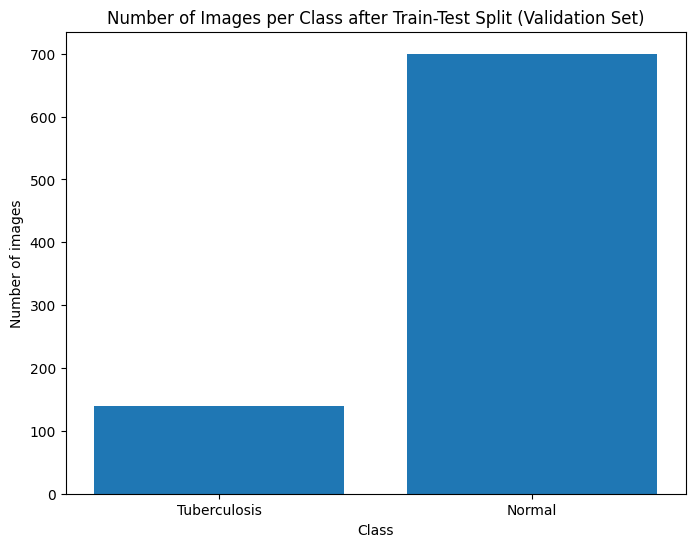

In [104]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Plot distribution of images after train-test split
plot_distribution(train_labels, 'Number of Images per Class after Train-Test Split (Train Set)')
plot_distribution(val_labels, 'Number of Images per Class after Train-Test Split (Validation Set)')


# Apply random undersampling to balance the classes in the training set

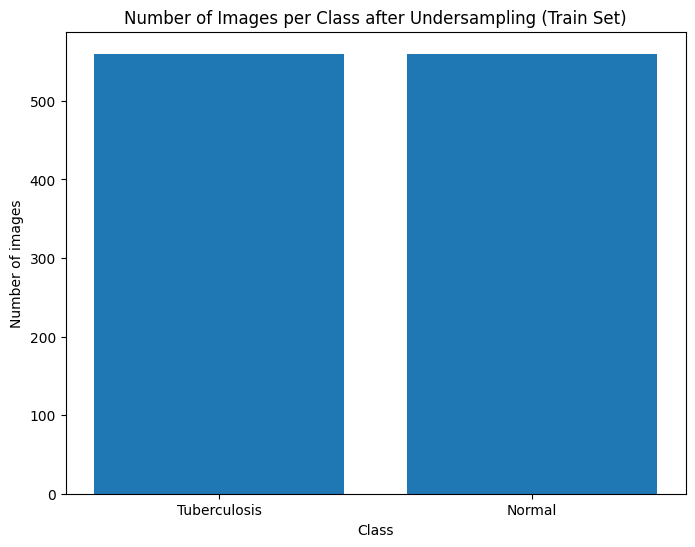

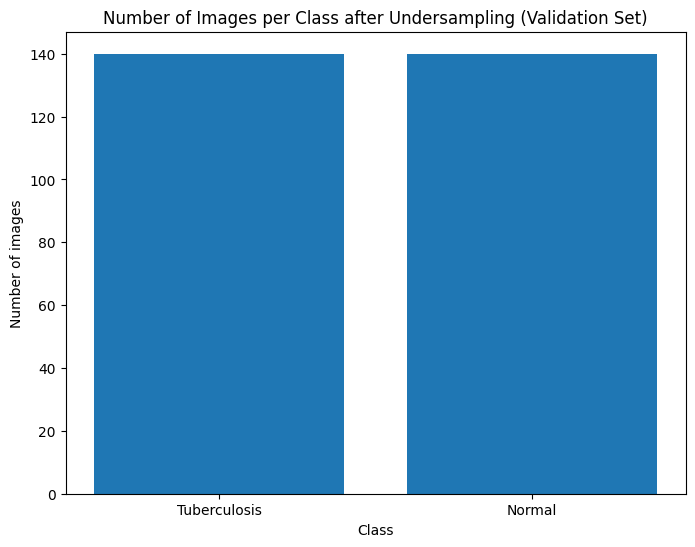

In [105]:
# Plot distribution of images after undersampling
rus = RandomUnderSampler()
train_paths, train_labels = rus.fit_resample(np.array(train_paths).reshape(-1, 1), train_labels)
train_paths = train_paths.flatten()
plot_distribution(train_labels, 'Number of Images per Class after Undersampling (Train Set)')
# Apply random undersampling to balance the classes in the validation set
val_paths, val_labels = rus.fit_resample(np.array(val_paths).reshape(-1, 1), val_labels)
val_paths = val_paths.flatten()
plot_distribution(val_labels, 'Number of Images per Class after Undersampling (Validation Set)')




In [106]:
# Copy images to respective directories and count them
def copy_images(image_paths, labels, target_dir):
    count = {class_name: 0 for class_name in class_names}
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        target_class_dir = os.path.join(target_dir, class_name)
        shutil.copy(img_path, target_class_dir)
        count[class_name] += 1
    return count

train_count = copy_images(train_paths, train_labels, train_dir)
val_count = copy_images(val_paths, val_labels, validation_dir)

print("Number of images copied for training after undersampling:")
print(train_count)

print("Number of images copied for validation after undersampling:")
print(val_count)





Number of images copied for training after undersampling:
{'Tuberculosis': 560, 'Normal': 560}
Number of images copied for validation after undersampling:
{'Tuberculosis': 140, 'Normal': 140}


## transfer learning with dense121

In [107]:
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(300, 300, 3))

# Add custom layers on top of the base model for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (1 output unit with sigmoid activation)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])




In [110]:
# Prepare data generators for training and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing the training data
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # Directory containing the validation data
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


## training

In [112]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=2)


Epoch 1/2
35/35 [==============================] - 570s 16s/step - loss: 0.2587 - accuracy: 0.8893 - val_loss: 0.1832 - val_accuracy: 0.9453
Epoch 2/2
35/35 [==============================] - 566s 16s/step - loss: 0.2482 - accuracy: 0.9098 - val_loss: 0.2175 - val_accuracy: 0.9141


In [ ]:
# Just try it unfreezing may be 2 layers or 5
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers for fine-tuning
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model for fine-tuning
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10)  # Adjust the number of epochs as needed




## Evaluating the model

In [113]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
# Predict the classes for the validation set
val_preds = model.predict(validation_generator)
val_preds_class = (val_preds > 0.5).astype(int)






9/9 [==============================] - 105s 11s/step


In [114]:
# Classification Report
true_classes = validation_generator.classes
print("Classification Report:")
print(classification_report(true_classes, val_preds_class))
true_classes = true_classes[:len(val_preds_class)]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       140
           1       0.99      0.79      0.88       140

    accuracy                           0.89       280
   macro avg       0.91      0.89      0.89       280
weighted avg       0.91      0.89      0.89       280



## Accuracy plotting

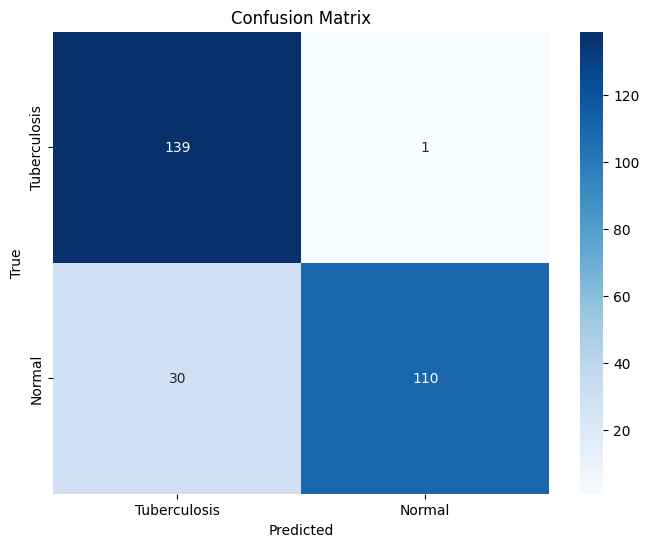

In [115]:
import seaborn as sns
# Compute the classification report
val_labels_true = validation_generator.classes
# Plot confusion matrix
conf_matrix = confusion_matrix(val_labels_true, val_preds_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


9/9 [==============================] - 101s 11s/step


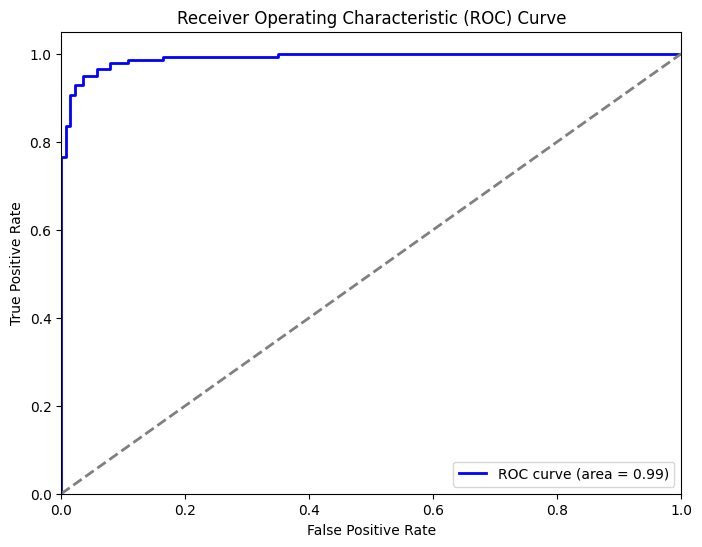

In [116]:
# Plot AUC-ROC curve
val_preds_prob = model.predict(validation_generator)
fpr, tpr, _ = roc_curve(val_labels_true, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()